# Logistic Regression

In [1]:
# 下载资料并做normalize，切为Training set和validation set
import numpy as np

np.random.seed(0)

x_train_fpath = '../data/X_train'
y_train_fpath = '../data/Y_train'
x_test_fpath  = '../data/X_test'

# 第一行是feature的名称，所以先执行next(f)跳过第一行的内容；第一个dimension是id，feature[1:]从第二个dimension开始读取
with open(x_train_fpath) as f:
    next(f)
    x_train = np.array([line.strip('\n').split(',')[1:]  for line in f], dtype = float)

with open(y_train_fpath) as f:
    next(f)
    y_train = np.array([line.strip('\n').split(',')[1]  for line in f], dtype = float)
    
with open(x_test_fpath) as f:
    next(f)
    x_test = np.array([line.strip('\n').split(',')[1:]   for line in f], dtype = float)
    
print('x_train :\n',x_train,x_train.shape,'\n')
print('y_train :\n',y_train,y_train.shape,'\n')
print('x_test :\n',x_test,x_test.shape)

x_train :
 [[33.  1.  0. ... 52.  0.  1.]
 [63.  1.  0. ... 52.  0.  1.]
 [71.  0.  0. ...  0.  0.  1.]
 ...
 [16.  0.  0. ...  8.  1.  0.]
 [48.  1.  0. ... 52.  0.  1.]
 [48.  0.  0. ...  0.  0.  1.]] (54256, 510) 

y_train :
 [1. 0. 0. ... 0. 0. 0.] (54256,) 

x_test :
 [[37.  1.  0. ... 52.  0.  1.]
 [48.  1.  0. ... 52.  0.  1.]
 [68.  0.  0. ...  0.  1.  0.]
 ...
 [38.  1.  0. ... 52.  0.  1.]
 [17.  0.  0. ... 40.  1.  0.]
 [22.  0.  0. ... 25.  1.  0.]] (27622, 510)


In [2]:
def _normalize(x, train = True, specified_column = None, x_mean = None, x_std = None):
    '''
    This function normalizes specific columns of x
    注意，testing data要跟training data的normalize方式一致，要用training data的mean和std，
    因此还需要input已知的x_mean和x_std
    '''
    # 如果没有指定列，那就穷举所有列，这里np.arange类似于range函数，只不过前者创造的对象是array类型
    if specified_column == None:
        specified_column = np.arange(x.shape[1])
    
    # train=True: for training data; train=False: for testing data，只计算training data的mean和std
    if train:
        # axis=0，对指定列求mean，注意np.mean返回的是一个列向量，因此需要用reshape(1,-1)转化成行向量
        x_mean = np.mean(x[:, specified_column], axis = 0).reshape(1, -1)
        # axis=0，对指定列求std
        x_std  = np.std(x[:, specified_column], axis = 0).reshape(1, -1)
     
    # 对指定列进行normalize，注意相减的两个向量行数不同但列数相同，相当于前者的每一行都减去x_mean这个行向量，除法同理
    # 分母加一个很小很小的数是为了避免标准差为0
    x[:, specified_column] = (x[:, specified_column] - x_mean) / (x_std + 1e-8)
    
    return x, x_mean, x_std

In [3]:
def _train_split(x, y, validation_ratio = 0.25):
    '''
    This function splits data into training set and validation set
    '''
    train_size = int(len(x) * (1 - validation_ratio))
    
    #return x,y of training set and validation set  
    # 如果返回值为x[:train_size, :]的话会报错，但这两种形式本质上是一样的，存疑
    return x[:train_size], y[:train_size], x[train_size:], y[train_size:]

In [4]:
# normalize training data and testing data
x_train, x_mean, x_std = _normalize(x_train, train = True)
x_test, _, _ = _normalize(x_test, train = False, x_mean = x_mean, x_std = x_std)

# split training data into training set and validation set
x_training_set, y_training_set, x_validation_set, y_validation_set = _train_split(x_train, y_train, validation_ratio = 0.1)

print('x_training_set : ', x_training_set.shape, '\n', x_training_set)
print('------------------------------------------------------------------------')
print('y_training_set : ', y_training_set.shape, '\n', y_training_set)
print('------------------------------------------------------------------------')
print('x_validation_set : ', x_validation_set.shape, '\n', x_validation_set)
print('------------------------------------------------------------------------')
print('y_validation_set : ', y_validation_set.shape, '\n', y_validation_set)

x_training_set :  (48830, 510) 
 [[-0.42755297  0.99959458 -0.1822401  ...  0.80645987 -1.01485522
   1.01485522]
 [ 1.19978056  0.99959458 -0.1822401  ...  0.80645987 -1.01485522
   1.01485522]
 [ 1.63373617 -1.00040555 -0.1822401  ... -1.45536172 -1.01485522
   1.01485522]
 ...
 [ 0.65733605 -1.00040555 -0.1822401  ...  0.80645987 -1.01485522
   1.01485522]
 [ 0.27762489  0.99959458 -0.1822401  ...  0.28450104 -1.01485522
   1.01485522]
 [ 0.16913599 -1.00040555 -0.1822401  ...  0.80645987  0.98536219
  -0.98536219]]
------------------------------------------------------------------------
y_training_set :  (48830,) 
 [1. 0. 0. ... 1. 0. 0.]
------------------------------------------------------------------------
x_validation_set :  (5426, 510) 
 [[-0.48179742  0.99959458 -0.1822401  ...  0.80645987  0.98536219
  -0.98536219]
 [-1.24121974 -1.00040555  5.48726602 ...  0.80645987 -1.01485522
   1.01485522]
 [-0.04784181  0.99959458 -0.1822401  ...  0.80645987 -1.01485522
   1.01485522]

In [5]:
# some useful functions
# np.dot()的作用主要体现在两个1-D向量相乘和一个N-D矩阵和一个1-D向量相乘的情景下：
# 两个1-D向量A与B相乘(A、B元素数量必须相等)：等价于A、B对应元素相乘并累计求和，最终得到一个常量积；注意A*B和np.dot(A,B)的区别，前者是A、B对应元素相乘，每次相乘的积都作为新的1-D向量的一个元素，而不是把这些积累加为一个常量
# 一个N-D矩阵A和一个1-D向量B相乘(A的每一行元素数量必须与B的元素数量相等)：等价于把这个N-D矩阵A拆成N个1-D向量，它们分别与B做1-D矩阵的相乘，得到的积作为结果的一个元素，总共有N个积，最终的结果就是由这N个积组成的1-D向量
# np.dot()在w*x上的应用可以减少转置，在其他方面也有比较便利的应用
def _shuffle(x, y):
    '''
    This function shuffles two equal-length list/array, x and y, together
    '''
    # 打乱原本的次序
    randomize = np.arange(len(x))
    np.random.shuffle(randomize)
    
    return x[randomize], y[randomize]

def _sigmoid(z):
    '''
    sigmoid function can be used to calculate probability
    To avoid overflow, minimum/maximum output value is set
    '''
    # np.clip(a, a_min, a_max)将数组a限制在a_min和a_max之间，超出范围的值将被赋以边界值
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(x, w, b):
    '''
    logistic regression function, parameterized by w and b
    
    Arguements:
        X: input data, shape = [batch_size, data_dimension]
        w: weight vector, shape = [data_dimension, ]
        b: bias, scalar
    output:
        predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    '''
    # np.dot特别适合用来计算x*w，无需转置，直接就是N维x的每一行与一维w相乘得到的结果汇总成一个一维的y
    return _sigmoid(np.dot(x, w) + b)

def _predict(x, w, b):
    '''
    This function returns a truth value prediction for each row of x
    by round function to make 0 or 1
    '''
    # 利用round函数的四舍五入功能把概率转化成0或1
    return np.round(_f(x, w, b)).astype(np.int)
    
def _accuracy(y_predict, y_label):
    '''
    This function calculates prediction accuracy
    '''
    # 预测值和标签值相减，取绝对值后再求平均，相当于预测错误的个数(差为1)/总个数，即错误率，1-错误率即正确率
    acc = 1 - np.mean(np.abs(y_predict - y_label))
    
    return acc

In [6]:
# loss function(cross_entropy) and gradient
def _cross_entropy_loss(y_predict, y_label):
    '''
    This function computes the cross entropy 
    
    Arguements:
        y_pred: probabilistic predictions, float vector
        Y_label: ground truth labels, bool vector
    Output:
        cross entropy, scalar    
    '''
    # cross_entropy = -Σ(y_head*ln(y)+(1-y_head)*ln(1-y))
    # 注意，这里的np.dot可以直接计算两个一位矩阵的积(前提是元素个数一致)，无需转置；np.log()等价于ln()
    # 因此这里的矩阵积实际上已经做了Σ的工作，左边的np.dot计算的是Σ(y_head*ln(y)，右边的np.dot计算的是Σ(1-y_head)*ln(1-y))
    cross_entropy = -(np.dot(y_label, np.log(y_predict)) + np.dot((1 - y_label), np.log(1 - y_predict)))
    
    return cross_entropy

def _gradient(x, y_label, w, b):
    '''
    This function computes the gradient of cross entropy loss with respect to weight w and bias b
    loss function: -Σ (y_head*ln(y)+(1-y_head)*ln(1-y)), 分别对w和b求偏微分，可得
    gradient of w: -Σ（y_head - y)*x
    gradient of b: -Σ（y_head - y)
    '''
    y_predict = _f(x, w, b)
    # 也可以是w_gradient = -np.dot(x.T, y_label - y_predict)
    w_gradient = -np.sum((y_label - y_predict) * x.T, 1)
    b_gradient = -np.sum(y_label - y_predict)
    
    return w_gradient, b_gradient

In [7]:
# mini-batch stochastic-gradient-descent

train_size = x_training_set.shape[0]
validation_size = x_validation_set.shape[0]
dim = x_training_set.shape[1]
# initialize w and b
w = np.zeros(dim)
b= np.zeros(1)

# parameters for training
max_iter = 1000
learning_rate = 1

# save the loss and accuracy
training_set_loss = []
training_set_acc = []
validation_set_loss = []
validation_set_acc = []

w_adagrad = 1e-8
b_adagrad = 1e-8


# training for iterations
for epoch in range(max_iter):
        
    # compute the gradient
    w_gradient, b_gradient = _gradient(x_training_set, y_training_set, w, b)

    # compute the adagrad
    w_adagrad = w_adagrad + np.power(w_gradient, 2)
    b_adagrad = b_adagrad + np.power(b_gradient, 2)

    # gradient descent update 
    # learning rate decay with time
    w = w - learning_rate * w_gradient / np.sqrt(w_adagrad)
    b = b - learning_rate * b_gradient / np.sqrt(b_adagrad)

        
    # one epoch: compute loss and accuracy of training set and validation set
    y_training_predict = _predict(x_training_set, w, b) # predict函数将Probability取round，只剩下0和1
    y_probability = _f(x_training_set, w, b) # Probability用来计算cross_entropy，不能用round后的值，否则会出现ln(0)的错误
    acc = _accuracy(y_training_predict, y_training_set)
    loss = _cross_entropy_loss(y_probability, y_training_set) / train_size # average cross_entropy
    training_set_acc.append(acc)
    training_set_loss.append(loss)
    print('training_set_acc_%d   : %f \t training_set_loss_%d  : %f'%(epoch, acc, epoch, loss))
    
    y_validation_predict = _predict(x_validation_set, w, b)
    y_probability = _f(x_validation_set, w, b)
    acc = _accuracy(y_validation_predict, y_validation_set)
    loss = _cross_entropy_loss(y_probability, y_validation_set) / validation_size # average cross_entropy
    validation_set_acc.append(acc)
    validation_set_loss.append(loss)
    
print('validation_set_acc_%d : %f \t validation_set_loss_%d : %f'%(epoch, acc, epoch, loss))
print()
   

training_set_acc_0   : 0.617121 	 training_set_loss_0  : 5.640612
training_set_acc_1   : 0.752713 	 training_set_loss_1  : 2.487458
training_set_acc_2   : 0.689166 	 training_set_loss_2  : 2.192208
training_set_acc_3   : 0.653676 	 training_set_loss_3  : 3.330357
training_set_acc_4   : 0.713455 	 training_set_loss_4  : 1.892609
training_set_acc_5   : 0.730924 	 training_set_loss_5  : 1.772177
training_set_acc_6   : 0.759390 	 training_set_loss_6  : 1.384826
training_set_acc_7   : 0.700246 	 training_set_loss_7  : 1.762264
training_set_acc_8   : 0.649744 	 training_set_loss_8  : 2.965974
training_set_acc_9   : 0.826377 	 training_set_loss_9  : 1.096059
training_set_acc_10   : 0.839238 	 training_set_loss_10  : 0.783955
training_set_acc_11   : 0.851915 	 training_set_loss_11  : 0.694956
training_set_acc_12   : 0.833463 	 training_set_loss_12  : 0.691637
training_set_acc_13   : 0.828978 	 training_set_loss_13  : 0.794507
training_set_acc_14   : 0.800246 	 training_set_loss_14  : 0.978337


training_set_acc_121   : 0.859533 	 training_set_loss_121  : 0.365939
training_set_acc_122   : 0.855089 	 training_set_loss_122  : 0.369427
training_set_acc_123   : 0.859758 	 training_set_loss_123  : 0.363435
training_set_acc_124   : 0.855826 	 training_set_loss_124  : 0.366621
training_set_acc_125   : 0.860229 	 training_set_loss_125  : 0.359641
training_set_acc_126   : 0.856134 	 training_set_loss_126  : 0.365582
training_set_acc_127   : 0.860414 	 training_set_loss_127  : 0.359350
training_set_acc_128   : 0.856523 	 training_set_loss_128  : 0.363230
training_set_acc_129   : 0.860557 	 training_set_loss_129  : 0.357016
training_set_acc_130   : 0.856830 	 training_set_loss_130  : 0.361085
training_set_acc_131   : 0.860639 	 training_set_loss_131  : 0.355801
training_set_acc_132   : 0.857260 	 training_set_loss_132  : 0.359374
training_set_acc_133   : 0.860762 	 training_set_loss_133  : 0.353141
training_set_acc_134   : 0.857506 	 training_set_loss_134  : 0.358636
training_set_acc_135

training_set_acc_239   : 0.869425 	 training_set_loss_239  : 0.307866
training_set_acc_240   : 0.867704 	 training_set_loss_240  : 0.306500
training_set_acc_241   : 0.869691 	 training_set_loss_241  : 0.306339
training_set_acc_242   : 0.867766 	 training_set_loss_242  : 0.307016
training_set_acc_243   : 0.869568 	 training_set_loss_243  : 0.306854
training_set_acc_244   : 0.867889 	 training_set_loss_244  : 0.305776
training_set_acc_245   : 0.869732 	 training_set_loss_245  : 0.305827
training_set_acc_246   : 0.868073 	 training_set_loss_246  : 0.305694
training_set_acc_247   : 0.869588 	 training_set_loss_247  : 0.305937
training_set_acc_248   : 0.868380 	 training_set_loss_248  : 0.304722
training_set_acc_249   : 0.869834 	 training_set_loss_249  : 0.304399
training_set_acc_250   : 0.868278 	 training_set_loss_250  : 0.305133
training_set_acc_251   : 0.869670 	 training_set_loss_251  : 0.304834
training_set_acc_252   : 0.868482 	 training_set_loss_252  : 0.303995
training_set_acc_253

training_set_acc_357   : 0.872578 	 training_set_loss_357  : 0.288904
training_set_acc_358   : 0.873295 	 training_set_loss_358  : 0.290860
training_set_acc_359   : 0.872783 	 training_set_loss_359  : 0.289793
training_set_acc_360   : 0.873541 	 training_set_loss_360  : 0.290682
training_set_acc_361   : 0.872906 	 training_set_loss_361  : 0.289378
training_set_acc_362   : 0.873193 	 training_set_loss_362  : 0.290978
training_set_acc_363   : 0.873193 	 training_set_loss_363  : 0.289876
training_set_acc_364   : 0.873336 	 training_set_loss_364  : 0.290437
training_set_acc_365   : 0.873254 	 training_set_loss_365  : 0.289162
training_set_acc_366   : 0.873418 	 training_set_loss_366  : 0.290474
training_set_acc_367   : 0.873234 	 training_set_loss_367  : 0.289442
training_set_acc_368   : 0.873459 	 training_set_loss_368  : 0.289771
training_set_acc_369   : 0.873643 	 training_set_loss_369  : 0.288609
training_set_acc_370   : 0.873909 	 training_set_loss_370  : 0.289724
training_set_acc_371

training_set_acc_475   : 0.878292 	 training_set_loss_475  : 0.277953
training_set_acc_476   : 0.877944 	 training_set_loss_476  : 0.277372
training_set_acc_477   : 0.878333 	 training_set_loss_477  : 0.277405
training_set_acc_478   : 0.877944 	 training_set_loss_478  : 0.277499
training_set_acc_479   : 0.878353 	 training_set_loss_479  : 0.277674
training_set_acc_480   : 0.878128 	 training_set_loss_480  : 0.277106
training_set_acc_481   : 0.878456 	 training_set_loss_481  : 0.277136
training_set_acc_482   : 0.878128 	 training_set_loss_482  : 0.277233
training_set_acc_483   : 0.878476 	 training_set_loss_483  : 0.277404
training_set_acc_484   : 0.878292 	 training_set_loss_484  : 0.276850
training_set_acc_485   : 0.878415 	 training_set_loss_485  : 0.276875
training_set_acc_486   : 0.878210 	 training_set_loss_486  : 0.276977
training_set_acc_487   : 0.878538 	 training_set_loss_487  : 0.277142
training_set_acc_488   : 0.878353 	 training_set_loss_488  : 0.276602
training_set_acc_489

training_set_acc_594   : 0.881835 	 training_set_loss_594  : 0.272411
training_set_acc_595   : 0.880524 	 training_set_loss_595  : 0.272384
training_set_acc_596   : 0.882060 	 training_set_loss_596  : 0.272234
training_set_acc_597   : 0.880381 	 training_set_loss_597  : 0.272139
training_set_acc_598   : 0.882060 	 training_set_loss_598  : 0.272261
training_set_acc_599   : 0.880442 	 training_set_loss_599  : 0.272240
training_set_acc_600   : 0.882285 	 training_set_loss_600  : 0.272092
training_set_acc_601   : 0.880565 	 training_set_loss_601  : 0.272007
training_set_acc_602   : 0.882265 	 training_set_loss_602  : 0.272113
training_set_acc_603   : 0.880524 	 training_set_loss_603  : 0.272097
training_set_acc_604   : 0.882183 	 training_set_loss_604  : 0.271952
training_set_acc_605   : 0.880668 	 training_set_loss_605  : 0.271877
training_set_acc_606   : 0.882265 	 training_set_loss_606  : 0.271969
training_set_acc_607   : 0.880647 	 training_set_loss_607  : 0.271957
training_set_acc_608

training_set_acc_712   : 0.884129 	 training_set_loss_712  : 0.268207
training_set_acc_713   : 0.882879 	 training_set_loss_713  : 0.268288
training_set_acc_714   : 0.884170 	 training_set_loss_714  : 0.268167
training_set_acc_715   : 0.882879 	 training_set_loss_715  : 0.268248
training_set_acc_716   : 0.884190 	 training_set_loss_716  : 0.268128
training_set_acc_717   : 0.882920 	 training_set_loss_717  : 0.268210
training_set_acc_718   : 0.884190 	 training_set_loss_718  : 0.268090
training_set_acc_719   : 0.883043 	 training_set_loss_719  : 0.268173
training_set_acc_720   : 0.884251 	 training_set_loss_720  : 0.268053
training_set_acc_721   : 0.883084 	 training_set_loss_721  : 0.268137
training_set_acc_722   : 0.884333 	 training_set_loss_722  : 0.268017
training_set_acc_723   : 0.883146 	 training_set_loss_723  : 0.268102
training_set_acc_724   : 0.884354 	 training_set_loss_724  : 0.267982
training_set_acc_725   : 0.883105 	 training_set_loss_725  : 0.268068
training_set_acc_726

training_set_acc_830   : 0.883432 	 training_set_loss_830  : 0.267722
training_set_acc_831   : 0.883760 	 training_set_loss_831  : 0.267894
training_set_acc_832   : 0.883371 	 training_set_loss_832  : 0.267730
training_set_acc_833   : 0.883760 	 training_set_loss_833  : 0.267905
training_set_acc_834   : 0.883391 	 training_set_loss_834  : 0.267735
training_set_acc_835   : 0.883699 	 training_set_loss_835  : 0.267913
training_set_acc_836   : 0.883432 	 training_set_loss_836  : 0.267738
training_set_acc_837   : 0.883678 	 training_set_loss_837  : 0.267919
training_set_acc_838   : 0.883330 	 training_set_loss_838  : 0.267738
training_set_acc_839   : 0.883658 	 training_set_loss_839  : 0.267922
training_set_acc_840   : 0.883371 	 training_set_loss_840  : 0.267736
training_set_acc_841   : 0.883699 	 training_set_loss_841  : 0.267922
training_set_acc_842   : 0.883391 	 training_set_loss_842  : 0.267731
training_set_acc_843   : 0.883780 	 training_set_loss_843  : 0.267919
training_set_acc_844

training_set_acc_948   : 0.884579 	 training_set_loss_948  : 0.266152
training_set_acc_949   : 0.884825 	 training_set_loss_949  : 0.266289
training_set_acc_950   : 0.884497 	 training_set_loss_950  : 0.266129
training_set_acc_951   : 0.884825 	 training_set_loss_951  : 0.266264
training_set_acc_952   : 0.884538 	 training_set_loss_952  : 0.266105
training_set_acc_953   : 0.884845 	 training_set_loss_953  : 0.266239
training_set_acc_954   : 0.884538 	 training_set_loss_954  : 0.266082
training_set_acc_955   : 0.884866 	 training_set_loss_955  : 0.266215
training_set_acc_956   : 0.884518 	 training_set_loss_956  : 0.266060
training_set_acc_957   : 0.884907 	 training_set_loss_957  : 0.266191
training_set_acc_958   : 0.884579 	 training_set_loss_958  : 0.266038
training_set_acc_959   : 0.884989 	 training_set_loss_959  : 0.266168
training_set_acc_960   : 0.884641 	 training_set_loss_960  : 0.266016
training_set_acc_961   : 0.885050 	 training_set_loss_961  : 0.266145
training_set_acc_962

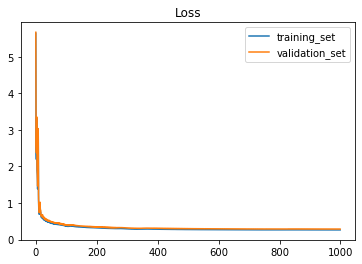

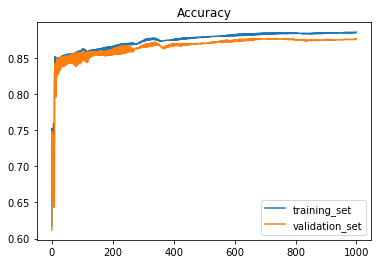

In [8]:
import matplotlib.pyplot as plt
# loss curve
plt.plot(training_set_loss)
plt.plot(validation_set_loss)
plt.title('Loss')
plt.legend(['training_set', 'validation_set'])
plt.savefig('loss_gd.png')
plt.show()

# accuracy curve
plt.plot(training_set_acc)
plt.plot(validation_set_acc)
plt.title('Accuracy')
plt.legend(['training_set', 'validation_set'])
plt.savefig('acc_gd.png')
plt.show()

In [9]:
# mini-batch stochastic-gradient-descent

train_size = x_train.shape[0]
dim = x_train.shape[1]
# initialize w and b
w = np.zeros(dim)
b= np.zeros(1)

# parameters for training
max_iter = 2000
learning_rate = 1

# save the loss and accuracy
train_loss = []
train_acc = []

w_adagrad = 1e-8
b_adagrad = 1e-8


# training for iterations
for epoch in range(max_iter):
        
    # compute the gradient
    w_gradient, b_gradient = _gradient(x_train, y_train, w, b)

    # compute the adagrad
    w_adagrad = w_adagrad + np.power(w_gradient, 2)
    b_adagrad = b_adagrad + np.power(b_gradient, 2)

    # gradient descent update 
    # learning rate decay with time
    w = w - learning_rate * w_gradient / np.sqrt(w_adagrad)
    b = b - learning_rate * b_gradient / np.sqrt(b_adagrad)
    
    y_train_predict = _predict(x_train, w, b) # predict函数将Probability取round，只剩下0和1
    y_probability = _f(x_train, w, b) # Probability用来计算cross_entropy，不能用round后的值，否则会出现ln(0)的错误
    acc = _accuracy(y_train_predict, y_train)
    loss = _cross_entropy_loss(y_probability, y_train) / train_size # average cross_entropy
    train_acc.append(acc)
    train_loss.append(loss)
    print('train_acc_%d   : %f \t train_loss_%d  : %f'%(epoch, acc, epoch, loss))
        

train_acc_0   : 0.616171 	 train_loss_0  : 5.665492
train_acc_1   : 0.748507 	 train_loss_1  : 2.511834
train_acc_2   : 0.689841 	 train_loss_2  : 2.259723
train_acc_3   : 0.651357 	 train_loss_3  : 3.362177
train_acc_4   : 0.717451 	 train_loss_4  : 1.847230
train_acc_5   : 0.726408 	 train_loss_5  : 1.770242
train_acc_6   : 0.761667 	 train_loss_6  : 1.352772
train_acc_7   : 0.720897 	 train_loss_7  : 1.516879
train_acc_8   : 0.669050 	 train_loss_8  : 2.469761
train_acc_9   : 0.793553 	 train_loss_9  : 1.313735
train_acc_10   : 0.787194 	 train_loss_10  : 1.233289
train_acc_11   : 0.828369 	 train_loss_11  : 0.871363
train_acc_12   : 0.815560 	 train_loss_12  : 0.895199
train_acc_13   : 0.839962 	 train_loss_13  : 0.767777
train_acc_14   : 0.830378 	 train_loss_14  : 0.750785
train_acc_15   : 0.846469 	 train_loss_15  : 0.670791
train_acc_16   : 0.833272 	 train_loss_16  : 0.695227
train_acc_17   : 0.846045 	 train_loss_17  : 0.648502
train_acc_18   : 0.832737 	 train_loss_18  : 0.6

train_acc_151   : 0.861453 	 train_loss_151  : 0.343758
train_acc_152   : 0.858762 	 train_loss_152  : 0.347962
train_acc_153   : 0.861343 	 train_loss_153  : 0.342776
train_acc_154   : 0.859112 	 train_loss_154  : 0.346383
train_acc_155   : 0.861582 	 train_loss_155  : 0.341472
train_acc_156   : 0.859057 	 train_loss_156  : 0.345447
train_acc_157   : 0.861508 	 train_loss_157  : 0.340548
train_acc_158   : 0.859610 	 train_loss_158  : 0.343949
train_acc_159   : 0.861859 	 train_loss_159  : 0.339307
train_acc_160   : 0.859573 	 train_loss_160  : 0.343075
train_acc_161   : 0.862135 	 train_loss_161  : 0.338441
train_acc_162   : 0.859794 	 train_loss_162  : 0.341654
train_acc_163   : 0.862448 	 train_loss_163  : 0.337266
train_acc_164   : 0.859960 	 train_loss_164  : 0.340842
train_acc_165   : 0.862522 	 train_loss_165  : 0.336457
train_acc_166   : 0.860071 	 train_loss_166  : 0.339499
train_acc_167   : 0.862614 	 train_loss_167  : 0.335343
train_acc_168   : 0.860015 	 train_loss_168  : 0

train_acc_298   : 0.874152 	 train_loss_298  : 0.296154
train_acc_299   : 0.872457 	 train_loss_299  : 0.293431
train_acc_300   : 0.874558 	 train_loss_300  : 0.295142
train_acc_301   : 0.872641 	 train_loss_301  : 0.292566
train_acc_302   : 0.874963 	 train_loss_302  : 0.294166
train_acc_303   : 0.872788 	 train_loss_303  : 0.291746
train_acc_304   : 0.875240 	 train_loss_304  : 0.293280
train_acc_305   : 0.873175 	 train_loss_305  : 0.290997
train_acc_306   : 0.875516 	 train_loss_306  : 0.292429
train_acc_307   : 0.873286 	 train_loss_307  : 0.290288
train_acc_308   : 0.875940 	 train_loss_308  : 0.291651
train_acc_309   : 0.873618 	 train_loss_309  : 0.289633
train_acc_310   : 0.875995 	 train_loss_310  : 0.290907
train_acc_311   : 0.874060 	 train_loss_311  : 0.289015
train_acc_312   : 0.876124 	 train_loss_312  : 0.290220
train_acc_313   : 0.874207 	 train_loss_313  : 0.288440
train_acc_314   : 0.876327 	 train_loss_314  : 0.289567
train_acc_315   : 0.874576 	 train_loss_315  : 0

train_acc_445   : 0.876235 	 train_loss_445  : 0.282261
train_acc_446   : 0.875664 	 train_loss_446  : 0.282392
train_acc_447   : 0.876345 	 train_loss_447  : 0.282080
train_acc_448   : 0.875756 	 train_loss_448  : 0.282210
train_acc_449   : 0.876438 	 train_loss_449  : 0.281901
train_acc_450   : 0.875829 	 train_loss_450  : 0.282031
train_acc_451   : 0.876419 	 train_loss_451  : 0.281725
train_acc_452   : 0.875885 	 train_loss_452  : 0.281854
train_acc_453   : 0.876548 	 train_loss_453  : 0.281551
train_acc_454   : 0.875940 	 train_loss_454  : 0.281680
train_acc_455   : 0.876567 	 train_loss_455  : 0.281380
train_acc_456   : 0.876069 	 train_loss_456  : 0.281509
train_acc_457   : 0.876548 	 train_loss_457  : 0.281211
train_acc_458   : 0.876143 	 train_loss_458  : 0.281339
train_acc_459   : 0.876474 	 train_loss_459  : 0.281044
train_acc_460   : 0.876253 	 train_loss_460  : 0.281172
train_acc_461   : 0.876511 	 train_loss_461  : 0.280879
train_acc_462   : 0.876382 	 train_loss_462  : 0

train_acc_592   : 0.881009 	 train_loss_592  : 0.273607
train_acc_593   : 0.880529 	 train_loss_593  : 0.273477
train_acc_594   : 0.881119 	 train_loss_594  : 0.273530
train_acc_595   : 0.880585 	 train_loss_595  : 0.273402
train_acc_596   : 0.881138 	 train_loss_596  : 0.273455
train_acc_597   : 0.880658 	 train_loss_597  : 0.273328
train_acc_598   : 0.881064 	 train_loss_598  : 0.273380
train_acc_599   : 0.880732 	 train_loss_599  : 0.273255
train_acc_600   : 0.881101 	 train_loss_600  : 0.273305
train_acc_601   : 0.880787 	 train_loss_601  : 0.273183
train_acc_602   : 0.881101 	 train_loss_602  : 0.273232
train_acc_603   : 0.880843 	 train_loss_603  : 0.273111
train_acc_604   : 0.881045 	 train_loss_604  : 0.273159
train_acc_605   : 0.880880 	 train_loss_605  : 0.273040
train_acc_606   : 0.881064 	 train_loss_606  : 0.273087
train_acc_607   : 0.880880 	 train_loss_607  : 0.272970
train_acc_608   : 0.881064 	 train_loss_608  : 0.273016
train_acc_609   : 0.880880 	 train_loss_609  : 0

train_acc_739   : 0.882594 	 train_loss_739  : 0.269635
train_acc_740   : 0.883792 	 train_loss_740  : 0.269636
train_acc_741   : 0.882594 	 train_loss_741  : 0.269580
train_acc_742   : 0.883902 	 train_loss_742  : 0.269578
train_acc_743   : 0.882649 	 train_loss_743  : 0.269526
train_acc_744   : 0.884013 	 train_loss_744  : 0.269522
train_acc_745   : 0.882741 	 train_loss_745  : 0.269472
train_acc_746   : 0.884087 	 train_loss_746  : 0.269466
train_acc_747   : 0.882741 	 train_loss_747  : 0.269419
train_acc_748   : 0.884142 	 train_loss_748  : 0.269411
train_acc_749   : 0.882833 	 train_loss_749  : 0.269367
train_acc_750   : 0.884123 	 train_loss_750  : 0.269356
train_acc_751   : 0.882833 	 train_loss_751  : 0.269315
train_acc_752   : 0.884160 	 train_loss_752  : 0.269302
train_acc_753   : 0.882815 	 train_loss_753  : 0.269263
train_acc_754   : 0.884123 	 train_loss_754  : 0.269248
train_acc_755   : 0.882723 	 train_loss_755  : 0.269212
train_acc_756   : 0.884142 	 train_loss_756  : 0

train_acc_886   : 0.885303 	 train_loss_886  : 0.266954
train_acc_887   : 0.883976 	 train_loss_887  : 0.266986
train_acc_888   : 0.885248 	 train_loss_888  : 0.266935
train_acc_889   : 0.884068 	 train_loss_889  : 0.266967
train_acc_890   : 0.885211 	 train_loss_890  : 0.266916
train_acc_891   : 0.884050 	 train_loss_891  : 0.266949
train_acc_892   : 0.885211 	 train_loss_892  : 0.266898
train_acc_893   : 0.884105 	 train_loss_893  : 0.266932
train_acc_894   : 0.885211 	 train_loss_894  : 0.266881
train_acc_895   : 0.884160 	 train_loss_895  : 0.266915
train_acc_896   : 0.885266 	 train_loss_896  : 0.266864
train_acc_897   : 0.884216 	 train_loss_897  : 0.266898
train_acc_898   : 0.885229 	 train_loss_898  : 0.266847
train_acc_899   : 0.884216 	 train_loss_899  : 0.266882
train_acc_900   : 0.885211 	 train_loss_900  : 0.266831
train_acc_901   : 0.884234 	 train_loss_901  : 0.266866
train_acc_902   : 0.885248 	 train_loss_902  : 0.266815
train_acc_903   : 0.884271 	 train_loss_903  : 0

train_acc_1032   : 0.883497 	 train_loss_1032  : 0.267869
train_acc_1033   : 0.883884 	 train_loss_1033  : 0.267932
train_acc_1034   : 0.883515 	 train_loss_1034  : 0.267897
train_acc_1035   : 0.883921 	 train_loss_1035  : 0.267959
train_acc_1036   : 0.883405 	 train_loss_1036  : 0.267921
train_acc_1037   : 0.883921 	 train_loss_1037  : 0.267983
train_acc_1038   : 0.883331 	 train_loss_1038  : 0.267941
train_acc_1039   : 0.883921 	 train_loss_1039  : 0.268003
train_acc_1040   : 0.883368 	 train_loss_1040  : 0.267958
train_acc_1041   : 0.883921 	 train_loss_1041  : 0.268019
train_acc_1042   : 0.883331 	 train_loss_1042  : 0.267972
train_acc_1043   : 0.883994 	 train_loss_1043  : 0.268032
train_acc_1044   : 0.883294 	 train_loss_1044  : 0.267981
train_acc_1045   : 0.884031 	 train_loss_1045  : 0.268041
train_acc_1046   : 0.883331 	 train_loss_1046  : 0.267988
train_acc_1047   : 0.883994 	 train_loss_1047  : 0.268046
train_acc_1048   : 0.883331 	 train_loss_1048  : 0.267991
train_acc_1049

train_acc_1174   : 0.884529 	 train_loss_1174  : 0.266845
train_acc_1175   : 0.885027 	 train_loss_1175  : 0.266884
train_acc_1176   : 0.884529 	 train_loss_1176  : 0.266832
train_acc_1177   : 0.885174 	 train_loss_1177  : 0.266870
train_acc_1178   : 0.884584 	 train_loss_1178  : 0.266818
train_acc_1179   : 0.885174 	 train_loss_1179  : 0.266856
train_acc_1180   : 0.884566 	 train_loss_1180  : 0.266805
train_acc_1181   : 0.885156 	 train_loss_1181  : 0.266842
train_acc_1182   : 0.884676 	 train_loss_1182  : 0.266791
train_acc_1183   : 0.885174 	 train_loss_1183  : 0.266829
train_acc_1184   : 0.884695 	 train_loss_1184  : 0.266778
train_acc_1185   : 0.885266 	 train_loss_1185  : 0.266816
train_acc_1186   : 0.884787 	 train_loss_1186  : 0.266765
train_acc_1187   : 0.885303 	 train_loss_1187  : 0.266803
train_acc_1188   : 0.884805 	 train_loss_1188  : 0.266753
train_acc_1189   : 0.885248 	 train_loss_1189  : 0.266790
train_acc_1190   : 0.884769 	 train_loss_1190  : 0.266740
train_acc_1191

train_acc_1316   : 0.885045 	 train_loss_1316  : 0.266186
train_acc_1317   : 0.885192 	 train_loss_1317  : 0.266214
train_acc_1318   : 0.885063 	 train_loss_1318  : 0.266180
train_acc_1319   : 0.885211 	 train_loss_1319  : 0.266208
train_acc_1320   : 0.885137 	 train_loss_1320  : 0.266174
train_acc_1321   : 0.885229 	 train_loss_1321  : 0.266202
train_acc_1322   : 0.885137 	 train_loss_1322  : 0.266168
train_acc_1323   : 0.885211 	 train_loss_1323  : 0.266196
train_acc_1324   : 0.885119 	 train_loss_1324  : 0.266162
train_acc_1325   : 0.885174 	 train_loss_1325  : 0.266190
train_acc_1326   : 0.885156 	 train_loss_1326  : 0.266156
train_acc_1327   : 0.885211 	 train_loss_1327  : 0.266184
train_acc_1328   : 0.885192 	 train_loss_1328  : 0.266150
train_acc_1329   : 0.885174 	 train_loss_1329  : 0.266178
train_acc_1330   : 0.885192 	 train_loss_1330  : 0.266145
train_acc_1331   : 0.885174 	 train_loss_1331  : 0.266172
train_acc_1332   : 0.885229 	 train_loss_1332  : 0.266139
train_acc_1333

train_acc_1458   : 0.885543 	 train_loss_1458  : 0.265878
train_acc_1459   : 0.885340 	 train_loss_1459  : 0.265900
train_acc_1460   : 0.885506 	 train_loss_1460  : 0.265875
train_acc_1461   : 0.885321 	 train_loss_1461  : 0.265897
train_acc_1462   : 0.885506 	 train_loss_1462  : 0.265872
train_acc_1463   : 0.885321 	 train_loss_1463  : 0.265894
train_acc_1464   : 0.885524 	 train_loss_1464  : 0.265869
train_acc_1465   : 0.885321 	 train_loss_1465  : 0.265891
train_acc_1466   : 0.885524 	 train_loss_1466  : 0.265866
train_acc_1467   : 0.885340 	 train_loss_1467  : 0.265888
train_acc_1468   : 0.885561 	 train_loss_1468  : 0.265863
train_acc_1469   : 0.885358 	 train_loss_1469  : 0.265885
train_acc_1470   : 0.885543 	 train_loss_1470  : 0.265860
train_acc_1471   : 0.885377 	 train_loss_1471  : 0.265882
train_acc_1472   : 0.885524 	 train_loss_1472  : 0.265857
train_acc_1473   : 0.885340 	 train_loss_1473  : 0.265879
train_acc_1474   : 0.885487 	 train_loss_1474  : 0.265854
train_acc_1475

train_acc_1600   : 0.885653 	 train_loss_1600  : 0.265716
train_acc_1601   : 0.885266 	 train_loss_1601  : 0.265734
train_acc_1602   : 0.885616 	 train_loss_1602  : 0.265714
train_acc_1603   : 0.885266 	 train_loss_1603  : 0.265732
train_acc_1604   : 0.885635 	 train_loss_1604  : 0.265713
train_acc_1605   : 0.885248 	 train_loss_1605  : 0.265731
train_acc_1606   : 0.885635 	 train_loss_1606  : 0.265711
train_acc_1607   : 0.885266 	 train_loss_1607  : 0.265729
train_acc_1608   : 0.885653 	 train_loss_1608  : 0.265709
train_acc_1609   : 0.885266 	 train_loss_1609  : 0.265727
train_acc_1610   : 0.885635 	 train_loss_1610  : 0.265708
train_acc_1611   : 0.885229 	 train_loss_1611  : 0.265726
train_acc_1612   : 0.885653 	 train_loss_1612  : 0.265706
train_acc_1613   : 0.885229 	 train_loss_1613  : 0.265724
train_acc_1614   : 0.885635 	 train_loss_1614  : 0.265704
train_acc_1615   : 0.885211 	 train_loss_1615  : 0.265722
train_acc_1616   : 0.885672 	 train_loss_1616  : 0.265703
train_acc_1617

train_acc_1742   : 0.885487 	 train_loss_1742  : 0.265622
train_acc_1743   : 0.885192 	 train_loss_1743  : 0.265637
train_acc_1744   : 0.885506 	 train_loss_1744  : 0.265621
train_acc_1745   : 0.885174 	 train_loss_1745  : 0.265636
train_acc_1746   : 0.885487 	 train_loss_1746  : 0.265620
train_acc_1747   : 0.885192 	 train_loss_1747  : 0.265635
train_acc_1748   : 0.885487 	 train_loss_1748  : 0.265619
train_acc_1749   : 0.885211 	 train_loss_1749  : 0.265634
train_acc_1750   : 0.885487 	 train_loss_1750  : 0.265618
train_acc_1751   : 0.885229 	 train_loss_1751  : 0.265633
train_acc_1752   : 0.885487 	 train_loss_1752  : 0.265617
train_acc_1753   : 0.885248 	 train_loss_1753  : 0.265632
train_acc_1754   : 0.885524 	 train_loss_1754  : 0.265616
train_acc_1755   : 0.885285 	 train_loss_1755  : 0.265631
train_acc_1756   : 0.885506 	 train_loss_1756  : 0.265615
train_acc_1757   : 0.885303 	 train_loss_1757  : 0.265630
train_acc_1758   : 0.885506 	 train_loss_1758  : 0.265614
train_acc_1759

train_acc_1884   : 0.885727 	 train_loss_1884  : 0.265562
train_acc_1885   : 0.885303 	 train_loss_1885  : 0.265575
train_acc_1886   : 0.885727 	 train_loss_1886  : 0.265561
train_acc_1887   : 0.885285 	 train_loss_1887  : 0.265574
train_acc_1888   : 0.885745 	 train_loss_1888  : 0.265560
train_acc_1889   : 0.885285 	 train_loss_1889  : 0.265573
train_acc_1890   : 0.885708 	 train_loss_1890  : 0.265560
train_acc_1891   : 0.885266 	 train_loss_1891  : 0.265572
train_acc_1892   : 0.885708 	 train_loss_1892  : 0.265559
train_acc_1893   : 0.885266 	 train_loss_1893  : 0.265572
train_acc_1894   : 0.885727 	 train_loss_1894  : 0.265558
train_acc_1895   : 0.885248 	 train_loss_1895  : 0.265571
train_acc_1896   : 0.885727 	 train_loss_1896  : 0.265558
train_acc_1897   : 0.885248 	 train_loss_1897  : 0.265570
train_acc_1898   : 0.885727 	 train_loss_1898  : 0.265557
train_acc_1899   : 0.885248 	 train_loss_1899  : 0.265570
train_acc_1900   : 0.885727 	 train_loss_1900  : 0.265556
train_acc_1901

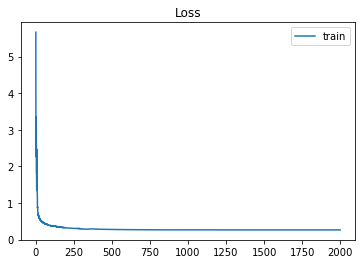

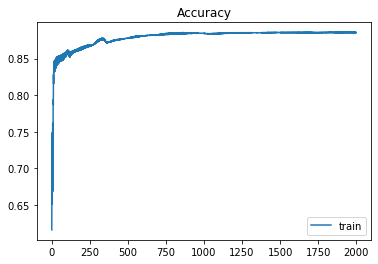

In [10]:
# loss curve
plt.plot(train_loss)
plt.title('Loss')
plt.legend(['train'])
plt.show()

# accuracy curve
plt.plot(train_acc)
plt.title('Accuracy')
plt.legend(['train'])
plt.show()

np.save('weight_adagrad_gd.npy', w)
np.save('bias_adagrad_gd.npy', b)

In [11]:
# predict testing data
import csv
# w = np.load('weight_adagrad.npy')
# b = np.load('bias_adagrad.npy')
y_test_predict = _predict(x_test, w, b)
print(y_test_predict, y_test_predict.shape)

with open('predict_adagrad_gd.csv', mode = 'w', newline = '') as f:
    csv_writer = csv.writer(f)
    header = ['id', 'label']
    print(header)
    csv_writer.writerow(header)
    for i in range(y_test_predict.shape[0]):
        row = [str(i), y_test_predict[i]]
        csv_writer.writerow(row)
        print(row)

[0 0 0 ... 1 0 0] (27622,)
['id', 'label']
['0', 0]
['1', 0]
['2', 0]
['3', 0]
['4', 0]
['5', 1]
['6', 0]
['7', 1]
['8', 0]
['9', 0]
['10', 0]
['11', 0]
['12', 1]
['13', 0]
['14', 0]
['15', 0]
['16', 0]
['17', 0]
['18', 0]
['19', 0]
['20', 1]
['21', 0]
['22', 0]
['23', 0]
['24', 0]
['25', 0]
['26', 0]
['27', 0]
['28', 0]
['29', 0]
['30', 0]
['31', 0]
['32', 0]
['33', 1]
['34', 0]
['35', 0]
['36', 0]
['37', 0]
['38', 0]
['39', 0]
['40', 0]
['41', 0]
['42', 1]
['43', 0]
['44', 0]
['45', 0]
['46', 0]
['47', 0]
['48', 0]
['49', 0]
['50', 0]
['51', 0]
['52', 0]
['53', 0]
['54', 0]
['55', 0]
['56', 0]
['57', 0]
['58', 0]
['59', 0]
['60', 0]
['61', 0]
['62', 0]
['63', 0]
['64', 0]
['65', 0]
['66', 0]
['67', 0]
['68', 1]
['69', 0]
['70', 0]
['71', 0]
['72', 0]
['73', 0]
['74', 0]
['75', 0]
['76', 0]
['77', 1]
['78', 1]
['79', 0]
['80', 0]
['81', 0]
['82', 0]
['83', 0]
['84', 0]
['85', 0]
['86', 0]
['87', 0]
['88', 0]
['89', 0]
['90', 0]
['91', 0]
['92', 0]
['93', 0]
['94', 1]
['95', 0]
['96', 

['1161', 1]
['1162', 1]
['1163', 0]
['1164', 0]
['1165', 0]
['1166', 0]
['1167', 0]
['1168', 0]
['1169', 0]
['1170', 0]
['1171', 0]
['1172', 1]
['1173', 0]
['1174', 0]
['1175', 1]
['1176', 0]
['1177', 0]
['1178', 0]
['1179', 0]
['1180', 0]
['1181', 0]
['1182', 1]
['1183', 0]
['1184', 0]
['1185', 0]
['1186', 0]
['1187', 0]
['1188', 0]
['1189', 0]
['1190', 1]
['1191', 0]
['1192', 0]
['1193', 0]
['1194', 1]
['1195', 0]
['1196', 0]
['1197', 0]
['1198', 1]
['1199', 0]
['1200', 0]
['1201', 0]
['1202', 1]
['1203', 0]
['1204', 0]
['1205', 0]
['1206', 0]
['1207', 0]
['1208', 1]
['1209', 0]
['1210', 0]
['1211', 0]
['1212', 0]
['1213', 0]
['1214', 0]
['1215', 0]
['1216', 0]
['1217', 0]
['1218', 0]
['1219', 1]
['1220', 0]
['1221', 1]
['1222', 0]
['1223', 0]
['1224', 0]
['1225', 0]
['1226', 0]
['1227', 1]
['1228', 0]
['1229', 1]
['1230', 0]
['1231', 0]
['1232', 0]
['1233', 0]
['1234', 0]
['1235', 0]
['1236', 0]
['1237', 0]
['1238', 0]
['1239', 0]
['1240', 0]
['1241', 1]
['1242', 0]
['1243', 0]
['12

['2978', 0]
['2979', 0]
['2980', 0]
['2981', 0]
['2982', 0]
['2983', 0]
['2984', 0]
['2985', 0]
['2986', 1]
['2987', 0]
['2988', 0]
['2989', 0]
['2990', 0]
['2991', 0]
['2992', 1]
['2993', 0]
['2994', 0]
['2995', 0]
['2996', 0]
['2997', 0]
['2998', 0]
['2999', 0]
['3000', 0]
['3001', 0]
['3002', 0]
['3003', 0]
['3004', 0]
['3005', 0]
['3006', 1]
['3007', 1]
['3008', 0]
['3009', 0]
['3010', 1]
['3011', 0]
['3012', 0]
['3013', 1]
['3014', 0]
['3015', 0]
['3016', 0]
['3017', 1]
['3018', 0]
['3019', 0]
['3020', 0]
['3021', 0]
['3022', 0]
['3023', 1]
['3024', 0]
['3025', 0]
['3026', 0]
['3027', 1]
['3028', 0]
['3029', 0]
['3030', 0]
['3031', 0]
['3032', 0]
['3033', 0]
['3034', 0]
['3035', 0]
['3036', 0]
['3037', 0]
['3038', 0]
['3039', 0]
['3040', 0]
['3041', 0]
['3042', 0]
['3043', 0]
['3044', 1]
['3045', 0]
['3046', 0]
['3047', 0]
['3048', 0]
['3049', 0]
['3050', 0]
['3051', 0]
['3052', 1]
['3053', 1]
['3054', 0]
['3055', 0]
['3056', 0]
['3057', 1]
['3058', 1]
['3059', 0]
['3060', 0]
['30

['4977', 0]
['4978', 0]
['4979', 0]
['4980', 0]
['4981', 0]
['4982', 0]
['4983', 0]
['4984', 0]
['4985', 0]
['4986', 0]
['4987', 0]
['4988', 0]
['4989', 0]
['4990', 0]
['4991', 1]
['4992', 1]
['4993', 0]
['4994', 0]
['4995', 1]
['4996', 0]
['4997', 0]
['4998', 0]
['4999', 0]
['5000', 0]
['5001', 0]
['5002', 1]
['5003', 0]
['5004', 0]
['5005', 0]
['5006', 0]
['5007', 0]
['5008', 0]
['5009', 0]
['5010', 0]
['5011', 0]
['5012', 1]
['5013', 0]
['5014', 0]
['5015', 0]
['5016', 0]
['5017', 0]
['5018', 1]
['5019', 0]
['5020', 0]
['5021', 0]
['5022', 0]
['5023', 0]
['5024', 0]
['5025', 0]
['5026', 0]
['5027', 1]
['5028', 0]
['5029', 0]
['5030', 0]
['5031', 1]
['5032', 0]
['5033', 0]
['5034', 0]
['5035', 1]
['5036', 0]
['5037', 0]
['5038', 0]
['5039', 0]
['5040', 0]
['5041', 0]
['5042', 0]
['5043', 0]
['5044', 1]
['5045', 0]
['5046', 0]
['5047', 0]
['5048', 1]
['5049', 0]
['5050', 0]
['5051', 0]
['5052', 1]
['5053', 1]
['5054', 0]
['5055', 0]
['5056', 1]
['5057', 0]
['5058', 0]
['5059', 0]
['50

['7294', 0]
['7295', 1]
['7296', 0]
['7297', 1]
['7298', 0]
['7299', 0]
['7300', 0]
['7301', 0]
['7302', 0]
['7303', 0]
['7304', 0]
['7305', 0]
['7306', 0]
['7307', 0]
['7308', 0]
['7309', 0]
['7310', 1]
['7311', 0]
['7312', 0]
['7313', 0]
['7314', 0]
['7315', 0]
['7316', 0]
['7317', 0]
['7318', 1]
['7319', 0]
['7320', 0]
['7321', 0]
['7322', 0]
['7323', 0]
['7324', 0]
['7325', 0]
['7326', 0]
['7327', 0]
['7328', 0]
['7329', 0]
['7330', 0]
['7331', 0]
['7332', 1]
['7333', 0]
['7334', 0]
['7335', 1]
['7336', 0]
['7337', 0]
['7338', 0]
['7339', 0]
['7340', 0]
['7341', 0]
['7342', 0]
['7343', 0]
['7344', 0]
['7345', 0]
['7346', 0]
['7347', 0]
['7348', 0]
['7349', 0]
['7350', 1]
['7351', 0]
['7352', 0]
['7353', 1]
['7354', 0]
['7355', 0]
['7356', 0]
['7357', 0]
['7358', 1]
['7359', 0]
['7360', 0]
['7361', 1]
['7362', 0]
['7363', 0]
['7364', 0]
['7365', 0]
['7366', 0]
['7367', 1]
['7368', 0]
['7369', 0]
['7370', 0]
['7371', 1]
['7372', 0]
['7373', 1]
['7374', 0]
['7375', 0]
['7376', 0]
['73

['9476', 0]
['9477', 0]
['9478', 0]
['9479', 0]
['9480', 1]
['9481', 0]
['9482', 1]
['9483', 0]
['9484', 0]
['9485', 0]
['9486', 0]
['9487', 0]
['9488', 1]
['9489', 0]
['9490', 0]
['9491', 0]
['9492', 0]
['9493', 0]
['9494', 0]
['9495', 0]
['9496', 1]
['9497', 0]
['9498', 0]
['9499', 0]
['9500', 0]
['9501', 0]
['9502', 0]
['9503', 0]
['9504', 1]
['9505', 0]
['9506', 0]
['9507', 0]
['9508', 0]
['9509', 0]
['9510', 1]
['9511', 1]
['9512', 0]
['9513', 0]
['9514', 1]
['9515', 0]
['9516', 0]
['9517', 0]
['9518', 0]
['9519', 0]
['9520', 0]
['9521', 0]
['9522', 0]
['9523', 0]
['9524', 0]
['9525', 0]
['9526', 0]
['9527', 0]
['9528', 0]
['9529', 0]
['9530', 1]
['9531', 0]
['9532', 0]
['9533', 0]
['9534', 0]
['9535', 0]
['9536', 0]
['9537', 0]
['9538', 0]
['9539', 0]
['9540', 0]
['9541', 1]
['9542', 0]
['9543', 0]
['9544', 0]
['9545', 0]
['9546', 1]
['9547', 0]
['9548', 0]
['9549', 0]
['9550', 0]
['9551', 0]
['9552', 0]
['9553', 0]
['9554', 1]
['9555', 0]
['9556', 0]
['9557', 0]
['9558', 0]
['95

['11028', 0]
['11029', 0]
['11030', 0]
['11031', 0]
['11032', 0]
['11033', 1]
['11034', 0]
['11035', 0]
['11036', 0]
['11037', 0]
['11038', 0]
['11039', 0]
['11040', 0]
['11041', 1]
['11042', 0]
['11043', 0]
['11044', 0]
['11045', 0]
['11046', 0]
['11047', 0]
['11048', 0]
['11049', 0]
['11050', 1]
['11051', 0]
['11052', 0]
['11053', 0]
['11054', 1]
['11055', 0]
['11056', 0]
['11057', 0]
['11058', 0]
['11059', 0]
['11060', 1]
['11061', 0]
['11062', 0]
['11063', 1]
['11064', 0]
['11065', 0]
['11066', 0]
['11067', 0]
['11068', 0]
['11069', 0]
['11070', 0]
['11071', 0]
['11072', 0]
['11073', 0]
['11074', 0]
['11075', 0]
['11076', 1]
['11077', 0]
['11078', 0]
['11079', 0]
['11080', 0]
['11081', 0]
['11082', 0]
['11083', 1]
['11084', 0]
['11085', 0]
['11086', 0]
['11087', 1]
['11088', 0]
['11089', 0]
['11090', 1]
['11091', 0]
['11092', 0]
['11093', 0]
['11094', 0]
['11095', 0]
['11096', 0]
['11097', 0]
['11098', 0]
['11099', 0]
['11100', 0]
['11101', 0]
['11102', 0]
['11103', 1]
['11104', 0]

['13139', 0]
['13140', 0]
['13141', 1]
['13142', 0]
['13143', 0]
['13144', 0]
['13145', 0]
['13146', 0]
['13147', 1]
['13148', 0]
['13149', 0]
['13150', 0]
['13151', 0]
['13152', 0]
['13153', 0]
['13154', 0]
['13155', 0]
['13156', 0]
['13157', 0]
['13158', 1]
['13159', 0]
['13160', 1]
['13161', 0]
['13162', 0]
['13163', 0]
['13164', 0]
['13165', 1]
['13166', 0]
['13167', 0]
['13168', 0]
['13169', 1]
['13170', 0]
['13171', 0]
['13172', 0]
['13173', 1]
['13174', 0]
['13175', 0]
['13176', 0]
['13177', 0]
['13178', 0]
['13179', 0]
['13180', 1]
['13181', 0]
['13182', 0]
['13183', 0]
['13184', 0]
['13185', 0]
['13186', 0]
['13187', 1]
['13188', 0]
['13189', 0]
['13190', 0]
['13191', 0]
['13192', 0]
['13193', 0]
['13194', 1]
['13195', 0]
['13196', 0]
['13197', 0]
['13198', 0]
['13199', 0]
['13200', 0]
['13201', 0]
['13202', 0]
['13203', 0]
['13204', 0]
['13205', 0]
['13206', 0]
['13207', 0]
['13208', 0]
['13209', 0]
['13210', 0]
['13211', 0]
['13212', 1]
['13213', 0]
['13214', 0]
['13215', 0]

['15382', 0]
['15383', 1]
['15384', 0]
['15385', 0]
['15386', 0]
['15387', 0]
['15388', 0]
['15389', 1]
['15390', 0]
['15391', 0]
['15392', 0]
['15393', 0]
['15394', 0]
['15395', 0]
['15396', 0]
['15397', 0]
['15398', 0]
['15399', 1]
['15400', 0]
['15401', 1]
['15402', 0]
['15403', 0]
['15404', 1]
['15405', 0]
['15406', 0]
['15407', 0]
['15408', 1]
['15409', 0]
['15410', 0]
['15411', 0]
['15412', 0]
['15413', 0]
['15414', 0]
['15415', 0]
['15416', 1]
['15417', 0]
['15418', 0]
['15419', 0]
['15420', 0]
['15421', 0]
['15422', 1]
['15423', 0]
['15424', 0]
['15425', 0]
['15426', 1]
['15427', 0]
['15428', 0]
['15429', 0]
['15430', 0]
['15431', 1]
['15432', 0]
['15433', 0]
['15434', 0]
['15435', 0]
['15436', 0]
['15437', 0]
['15438', 0]
['15439', 0]
['15440', 0]
['15441', 1]
['15442', 1]
['15443', 0]
['15444', 0]
['15445', 0]
['15446', 0]
['15447', 0]
['15448', 0]
['15449', 0]
['15450', 0]
['15451', 0]
['15452', 0]
['15453', 0]
['15454', 1]
['15455', 0]
['15456', 1]
['15457', 1]
['15458', 0]

['16819', 0]
['16820', 0]
['16821', 0]
['16822', 1]
['16823', 0]
['16824', 0]
['16825', 0]
['16826', 0]
['16827', 0]
['16828', 0]
['16829', 0]
['16830', 0]
['16831', 0]
['16832', 1]
['16833', 0]
['16834', 1]
['16835', 0]
['16836', 0]
['16837', 1]
['16838', 0]
['16839', 0]
['16840', 0]
['16841', 0]
['16842', 0]
['16843', 1]
['16844', 0]
['16845', 0]
['16846', 0]
['16847', 1]
['16848', 0]
['16849', 0]
['16850', 1]
['16851', 0]
['16852', 0]
['16853', 0]
['16854', 0]
['16855', 0]
['16856', 0]
['16857', 0]
['16858', 0]
['16859', 0]
['16860', 1]
['16861', 0]
['16862', 0]
['16863', 1]
['16864', 1]
['16865', 0]
['16866', 0]
['16867', 1]
['16868', 0]
['16869', 1]
['16870', 0]
['16871', 1]
['16872', 0]
['16873', 1]
['16874', 0]
['16875', 0]
['16876', 0]
['16877', 0]
['16878', 0]
['16879', 0]
['16880', 0]
['16881', 0]
['16882', 0]
['16883', 0]
['16884', 1]
['16885', 0]
['16886', 0]
['16887', 0]
['16888', 0]
['16889', 0]
['16890', 0]
['16891', 0]
['16892', 0]
['16893', 0]
['16894', 0]
['16895', 0]

['19047', 0]
['19048', 0]
['19049', 0]
['19050', 0]
['19051', 0]
['19052', 1]
['19053', 0]
['19054', 0]
['19055', 1]
['19056', 0]
['19057', 0]
['19058', 0]
['19059', 0]
['19060', 1]
['19061', 0]
['19062', 1]
['19063', 0]
['19064', 0]
['19065', 1]
['19066', 1]
['19067', 1]
['19068', 0]
['19069', 0]
['19070', 0]
['19071', 0]
['19072', 0]
['19073', 1]
['19074', 0]
['19075', 0]
['19076', 0]
['19077', 0]
['19078', 1]
['19079', 0]
['19080', 0]
['19081', 0]
['19082', 0]
['19083', 0]
['19084', 0]
['19085', 0]
['19086', 1]
['19087', 0]
['19088', 0]
['19089', 1]
['19090', 0]
['19091', 0]
['19092', 0]
['19093', 0]
['19094', 0]
['19095', 1]
['19096', 0]
['19097', 0]
['19098', 0]
['19099', 0]
['19100', 0]
['19101', 0]
['19102', 0]
['19103', 1]
['19104', 0]
['19105', 0]
['19106', 0]
['19107', 1]
['19108', 0]
['19109', 0]
['19110', 1]
['19111', 0]
['19112', 0]
['19113', 0]
['19114', 0]
['19115', 0]
['19116', 0]
['19117', 1]
['19118', 0]
['19119', 0]
['19120', 0]
['19121', 0]
['19122', 1]
['19123', 0]

['21275', 0]
['21276', 0]
['21277', 0]
['21278', 0]
['21279', 0]
['21280', 0]
['21281', 0]
['21282', 0]
['21283', 0]
['21284', 0]
['21285', 0]
['21286', 0]
['21287', 0]
['21288', 0]
['21289', 0]
['21290', 0]
['21291', 0]
['21292', 0]
['21293', 0]
['21294', 0]
['21295', 0]
['21296', 0]
['21297', 0]
['21298', 0]
['21299', 0]
['21300', 0]
['21301', 0]
['21302', 0]
['21303', 0]
['21304', 0]
['21305', 0]
['21306', 0]
['21307', 1]
['21308', 0]
['21309', 0]
['21310', 0]
['21311', 0]
['21312', 0]
['21313', 0]
['21314', 0]
['21315', 0]
['21316', 1]
['21317', 0]
['21318', 0]
['21319', 0]
['21320', 1]
['21321', 0]
['21322', 0]
['21323', 0]
['21324', 0]
['21325', 0]
['21326', 0]
['21327', 0]
['21328', 0]
['21329', 0]
['21330', 0]
['21331', 0]
['21332', 0]
['21333', 0]
['21334', 0]
['21335', 0]
['21336', 0]
['21337', 0]
['21338', 0]
['21339', 1]
['21340', 0]
['21341', 0]
['21342', 0]
['21343', 0]
['21344', 0]
['21345', 1]
['21346', 0]
['21347', 0]
['21348', 0]
['21349', 0]
['21350', 0]
['21351', 0]

['24008', 0]
['24009', 0]
['24010', 0]
['24011', 1]
['24012', 0]
['24013', 1]
['24014', 0]
['24015', 0]
['24016', 0]
['24017', 0]
['24018', 0]
['24019', 0]
['24020', 1]
['24021', 0]
['24022', 0]
['24023', 0]
['24024', 0]
['24025', 0]
['24026', 1]
['24027', 0]
['24028', 0]
['24029', 0]
['24030', 0]
['24031', 0]
['24032', 0]
['24033', 0]
['24034', 0]
['24035', 1]
['24036', 0]
['24037', 0]
['24038', 0]
['24039', 0]
['24040', 0]
['24041', 0]
['24042', 0]
['24043', 0]
['24044', 0]
['24045', 0]
['24046', 1]
['24047', 0]
['24048', 0]
['24049', 0]
['24050', 0]
['24051', 0]
['24052', 0]
['24053', 0]
['24054', 0]
['24055', 0]
['24056', 0]
['24057', 1]
['24058', 1]
['24059', 0]
['24060', 0]
['24061', 0]
['24062', 0]
['24063', 1]
['24064', 1]
['24065', 0]
['24066', 1]
['24067', 0]
['24068', 0]
['24069', 0]
['24070', 0]
['24071', 0]
['24072', 0]
['24073', 0]
['24074', 0]
['24075', 0]
['24076', 0]
['24077', 1]
['24078', 0]
['24079', 1]
['24080', 0]
['24081', 0]
['24082', 0]
['24083', 0]
['24084', 0]

['25423', 0]
['25424', 0]
['25425', 0]
['25426', 0]
['25427', 0]
['25428', 0]
['25429', 0]
['25430', 0]
['25431', 0]
['25432', 0]
['25433', 0]
['25434', 0]
['25435', 0]
['25436', 0]
['25437', 1]
['25438', 1]
['25439', 0]
['25440', 1]
['25441', 0]
['25442', 0]
['25443', 0]
['25444', 0]
['25445', 0]
['25446', 0]
['25447', 0]
['25448', 0]
['25449', 0]
['25450', 1]
['25451', 0]
['25452', 0]
['25453', 0]
['25454', 0]
['25455', 0]
['25456', 0]
['25457', 1]
['25458', 1]
['25459', 0]
['25460', 0]
['25461', 0]
['25462', 0]
['25463', 0]
['25464', 0]
['25465', 0]
['25466', 0]
['25467', 0]
['25468', 0]
['25469', 1]
['25470', 0]
['25471', 0]
['25472', 0]
['25473', 1]
['25474', 0]
['25475', 0]
['25476', 0]
['25477', 0]
['25478', 0]
['25479', 0]
['25480', 0]
['25481', 0]
['25482', 0]
['25483', 0]
['25484', 0]
['25485', 0]
['25486', 0]
['25487', 0]
['25488', 1]
['25489', 0]
['25490', 0]
['25491', 0]
['25492', 1]
['25493', 0]
['25494', 0]
['25495', 0]
['25496', 0]
['25497', 0]
['25498', 0]
['25499', 0]